In [1]:
%load_ext cudf.pandas
import pandas as pd 
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [36]:
df = pd.read_csv('raw-data_recipe.csv')

In [37]:
df.head()

,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews
0,222388,Homemade Bacon,5.000000,https://images.media-allrecipes.com/userphotos...,3,pork belly^smoked paprika^kosher salt^ground b...,{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...,"{u'niacin': {u'hasCompleteData': False, u'name...","{8542392: {'rating': 5, 'followersCount': 11, ..."
1,240488,"Pork Loin, Apples, and Sauerkraut",4.764706,https://images.media-allrecipes.com/userphotos...,29,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3574785: {'rating': 5, 'followersCount': 0, '..."
2,218939,Foolproof Rosemary Chicken Wings,4.571429,https://images.media-allrecipes.com/userphotos...,12,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...","{13774946: {'rating': 5, 'followersCount': 0, ..."
3,87211,Chicken Pesto Paninis,4.625000,https://images.media-allrecipes.com/userphotos...,163,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1563136: {'rating': 5, 'followersCount': 0, '..."
4,245714,Potato Bacon Pizza,4.500000,https://images.media-allrecipes.com/userphotos...,2,red potatoes^strips bacon^Sauce:^heavy whippin...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{2945555: {'rating': 5, 'followersCount': 6690..."


In [38]:
# round average rating into 2 decimal places 
def avg_rate(col):
    return f'{col:.2f}'
df['aver_rate'] = df['aver_rate'].apply(avg_rate)

In [39]:
df.sample()

,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews
9484,34510,Pittsburgh Chipped Ham Barbecues,4.45,https://images.media-allrecipes.com/userphotos...,94,ketchup^water^brown sugar^cider vinegar^sweet ...,{'directions': u'Prep\n15 m\nCook\n20 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name...","{443909: {'rating': 5, 'followersCount': 0, 'm..."


In [40]:
# turn nutritions data from string to dictionary 
list_of_dict = []

for row in df['nutritions']:
    list_of_dict.append(literal_eval(row))

In [41]:
# extract percent daily values for selected nutritions 
calories_list = []
fat_list = []
carbohydrates_list = []
protein_list = []
cholestrol_list = []
sodium_list = []
fiber_list = []

for x in range(len(list_of_dict)):
    calories_list.append(list_of_dict[x]['calories']['percentDailyValue'])
    fat_list.append(list_of_dict[x]['fat']['percentDailyValue'])
    carbohydrates_list.append(list_of_dict[x]['carbohydrates']['percentDailyValue'])
    protein_list.append(list_of_dict[x]['protein']['percentDailyValue'])
    cholestrol_list.append(list_of_dict[x]['cholesterol']['percentDailyValue'])
    sodium_list.append(list_of_dict[x]['sodium']['percentDailyValue'])
    fiber_list.append(list_of_dict[x]['fiber']['percentDailyValue'])

In [42]:
# group all the data into dataframe 
data = {'calories': calories_list, 'fat':fat_list, 'carbohydrates':carbohydrates_list, 'protein':protein_list, 'cholesterol':cholestrol_list,
'sodium':sodium_list, 'fiber':fiber_list}

In [43]:
df_n = pd.DataFrame(data)
df_n['recipe_id'] = df['recipe_id']

In [44]:
df_n

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,recipe_id
0,15,36,< 1,42,21,81,2,222388
1,19,18,10,73,33,104,41,240488
2,17,36,2,48,24,31,4,218939
3,32,45,20,65,20,43,18,87211
4,8,12,5,14,7,8,3,245714
...,...,...,...,...,...,...,...,...
49693,20,< 1,6,< 1,0,< 1,0,222886
49694,6,14,2,4,13,3,< 1,25650
49695,8,7,8,10,3,3,8,23544
49696,20,33,16,11,25,7,5,170710


In [45]:
df_n.isnull().sum()

calories         963
fat              963
carbohydrates    963
protein          963
cholesterol      963
sodium           963
fiber            963
recipe_id          0
dtype: int64

In [46]:
df_n.dropna(inplace=True)
df_n.shape

(48735, 8)

In [47]:
# impute string data into numeric value
def text_cleaning(cols):
    if cols=='< 1':
        return 1 
    else:
        return cols

In [48]:
for col in df_n.columns:
    df_n[col] = df_n[col].apply(text_cleaning)

In [49]:
df_n.head()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,recipe_id
0,15,36,1,42,21,81,2,222388
1,19,18,10,73,33,104,41,240488
2,17,36,2,48,24,31,4,218939
3,32,45,20,65,20,43,18,87211
4,8,12,5,14,7,8,3,245714


In [50]:
df_n.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48735 entries, 0 to 49697
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   calories       48735 non-null  object
 1   fat            48735 non-null  object
 2   carbohydrates  48735 non-null  object
 3   protein        48735 non-null  object
 4   cholesterol    48735 non-null  object
 5   sodium         48735 non-null  object
 6   fiber          48735 non-null  object
 7   recipe_id      48735 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 3.3+ MB


In [51]:
df_n = df_n.apply(pd.to_numeric)

In [52]:
df_n.info()

<class 'cudf.core.dataframe.DataFrame'>
Index: 48735 entries, 0 to 49697
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   calories       48735 non-null  int64
 1   fat            48735 non-null  int64
 2   carbohydrates  48735 non-null  int64
 3   protein        48735 non-null  int64
 4   cholesterol    48735 non-null  int64
 5   sodium         48735 non-null  int64
 6   fiber          48735 non-null  int64
 7   recipe_id      48735 non-null  int64
dtypes: int64(8)
memory usage: 3.3 MB


In [53]:
df_n.set_index('recipe_id', inplace=True)

In [54]:
# normalized nutrition data by columns
df_normalized = pd.DataFrame(normalize(df_n, axis=0))
df_normalized.columns = df_n.columns
df_normalized.index = df_n.index 
df_normalized.head()

,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
recipe_id,,,,,,,
222388,0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560
240488,0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477
218939,0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120
87211,0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039
245714,0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840


In [55]:
df = df.merge(df_normalized, on='recipe_id')

In [56]:
df.head()

,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
0,222388,Homemade Bacon,5.00,https://images.media-allrecipes.com/userphotos...,3,pork belly^smoked paprika^kosher salt^ground b...,{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...,"{u'niacin': {u'hasCompleteData': False, u'name...","{8542392: {'rating': 5, 'followersCount': 11, ...",0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560
1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,https://images.media-allrecipes.com/userphotos...,29,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3574785: {'rating': 5, 'followersCount': 0, '...",0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477
2,218939,Foolproof Rosemary Chicken Wings,4.57,https://images.media-allrecipes.com/userphotos...,12,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...","{13774946: {'rating': 5, 'followersCount': 0, ...",0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120
3,87211,Chicken Pesto Paninis,4.62,https://images.media-allrecipes.com/userphotos...,163,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1563136: {'rating': 5, 'followersCount': 0, '...",0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039
4,245714,Potato Bacon Pizza,4.50,https://images.media-allrecipes.com/userphotos...,2,red potatoes^strips bacon^Sauce:^heavy whippin...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{2945555: {'rating': 5, 'followersCount': 6690...",0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840


In [57]:
del df_n 
del df_normalized

In [58]:
df['ingredients']= df['ingredients'].apply(lambda x:x.split('^'))

In [59]:
df.head()

column_view::get_data: Unsupported type: 24


,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber
0,222388,Homemade Bacon,5.00,https://images.media-allrecipes.com/userphotos...,3,"[pork belly, smoked paprika, kosher salt, grou...",{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...,"{u'niacin': {u'hasCompleteData': False, u'name...","{8542392: {'rating': 5, 'followersCount': 11, ...",0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560
1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,https://images.media-allrecipes.com/userphotos...,29,"[sauerkraut drained, Granny Smith apples slice...",{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3574785: {'rating': 5, 'followersCount': 0, '...",0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477
2,218939,Foolproof Rosemary Chicken Wings,4.57,https://images.media-allrecipes.com/userphotos...,12,"[chicken wings, sprigs rosemary, head garlic, ...","{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...","{13774946: {'rating': 5, 'followersCount': 0, ...",0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120
3,87211,Chicken Pesto Paninis,4.62,https://images.media-allrecipes.com/userphotos...,163,"[focaccia bread quartered, prepared basil pest...",{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1563136: {'rating': 5, 'followersCount': 0, '...",0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039
4,245714,Potato Bacon Pizza,4.50,https://images.media-allrecipes.com/userphotos...,2,"[red potatoes, strips bacon, Sauce:, heavy whi...",{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{2945555: {'rating': 5, 'followersCount': 6690...",0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840


In [60]:
df['ingredients'][0]

['pork belly', 'smoked paprika', 'kosher salt', 'ground black pepper']

In [61]:
df['ingredients'] = df['ingredients'].apply(lambda x : ','.join(x))

In [62]:
df['ingredients'][0]

'pork belly,smoked paprika,kosher salt,ground black pepper'

In [63]:
# Required Libraries for Word2Vec
import gensim
from nltk import sent_tokenize, word_tokenize
from gensim.utils import simple_preprocess

In [64]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/suyash/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/suyash/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/suyash/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/suyash/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/suyash/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_dat

True

In [65]:
story = []
for doc in df['ingredients']:
    raw_sent = word_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))

In [66]:
len(story)

1525542

In [67]:
# Model for Word2vec
model = gensim.models.Word2Vec(
    window = 1,
    vector_size = 20,
    min_count = 2
)

In [68]:
model.build_vocab(story)

In [69]:
# Word2vec model training
model.train(story, total_examples = model.corpus_count, epochs = model.epochs)

(3823643, 5584345)

In [70]:
# total number of words in word2vec vocabulary
len(model.wv.index_to_key)

3466

In [71]:
# Average word2vec (function for - one vector for one review)
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis = 0)

In [72]:
# Finally convering text data into vectors.
from tqdm import tqdm
X = [] # This list will contain all vectors.
count = 0
for doc in tqdm(df['ingredients'].values):
    try:                           # Exception handeling, to handel some wierd reviews i.e. hashtags, one word reviews
        count = count + 1
        X.append(document_vector(doc))
    except:            # Adding Randomly generated vector for some troublesome reviews.
        X.append(np.random.uniform(-1,1,(20,)))

100%|██████████| 48735/48735 [00:21<00:00, 2298.87it/s]


In [73]:
# Converting list into np.array
X = np.array(X)

In [74]:
# Cross check - shape of arary and dataset.
X.shape, df.shape

((48735, 20), (48735, 16))

In [89]:
X[213]

array([-0.14140578,  0.01854657, -0.16982831,  0.0300169 ,  0.0315133 ,
        0.06828898,  0.08637246, -0.01708528,  0.00854636,  0.11085105,
       -0.01841361,  0.02789698,  0.09269069,  0.07021157,  0.11266494,
       -0.07124893,  0.07842499, -0.0839972 , -0.1230189 ,  0.03018692])

In [98]:
df.reset_index(inplace=True)

In [100]:
liv = []
for i in tqdm(range((X.shape[0]))):
    l = np.append(X[i],df['calories'][i])
    l = np.append(l,df['fat'][i])
    l = np.append(l,df['carbohydrates'][i])
    l = np.append(l,df['protein'][i])
    l = np.append(l,df['cholesterol'][i])
    l = np.append(l,df['sodium'][i])
    l = np.append(l,df['fiber'][i])
    liv.append(l)

100%|██████████| 48735/48735 [13:57<00:00, 58.19it/s]


In [101]:
vectors = (np.array(liv))

In [102]:
vectors.shape

(48735, 27)

In [103]:
df['vectors']=liv

In [104]:
df.sample()

column_view::get_data: Unsupported type: 24


,index,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,vectors
12230,12332,48896,Company Liver with Onions,4.52,https://images.media-allrecipes.com/userphotos...,26,"butter,onions,calf's liver,salt,freshly ground...",{'directions': u'Prep\n15 m\nCook\n33 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1780843: {'rating': 5, 'followersCount': 28, ...",0.00507,0.007162,0.001407,0.005077,0.016414,0.001866,0.00168,"[-0.2506783604621887, 0.008460640907287598, -0..."


In [111]:
df.to_csv('df_vector.csv')

In [105]:
df[['calories', 'fat', 'carbohydrates', 'protein', 'cholesterol', 'sodium', 'fiber', 'ingredients', 'vectors']]

column_view::get_data: Unsupported type: 24
column_view::get_data: Unsupported type: 24
column_view::get_data: Unsupported type: 24
column_view::get_data: Unsupported type: 24
column_view::get_data: Unsupported type: 24
column_view::get_data: Unsupported type: 24


,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,ingredients,vectors
0,0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560,"pork belly,smoked paprika,kosher salt,ground b...","[-0.27893027663230896, 0.015008856542408466, -..."
1,0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477,"sauerkraut drained,Granny Smith apples sliced,...","[-0.11736796796321869, -0.001547161489725113, ..."
2,0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120,"chicken wings,sprigs rosemary,head garlic,oliv...","[-0.613681435585022, 0.08834049850702286, -0.7..."
3,0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039,"focaccia bread quartered,prepared basil pesto,...","[-0.28711050748825073, 0.07768359035253525, -0..."
4,0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840,"red potatoes,strips bacon,Sauce:,heavy whippin...","[-0.17853200435638428, 0.04251459613442421, -0..."
...,...,...,...,...,...,...,...,...,...
48730,0.004609,0.000133,0.002110,0.000113,0.000000,0.000081,0.000000,"fluid ounce tequila,fluid ounce vodka,fluid ou...","[-0.04282407835125923, -0.0014859068905934691,..."
48731,0.001383,0.001857,0.000703,0.000451,0.001855,0.000243,0.000280,"raisins,brandy,cream cheese,white sugar,all-pu...","[-0.05391816422343254, 0.04276260361075401, -0..."
48732,0.001844,0.000928,0.002814,0.001128,0.000428,0.000243,0.002239,"sliced peaches drained,scoops vanilla ice crea...","[-0.2725905776023865, 0.009774732403457165, -0..."
48733,0.004609,0.004377,0.005627,0.001241,0.003568,0.000568,0.001400,"butter,habanero peppers,fresh peaches,brown su...","[-0.3901863992214203, 0.006313790567219257, -0..."


In [106]:
df_new = df[['recipe_id', 'vectors']]

In [107]:
df_new.set_index('recipe_id', inplace=True)

In [108]:
from time import time
def nutrition_recommender(recipe_name):
    start = time()
    recipe_id = df[df['recipe_name']==recipe_name].set_index('recipe_id').index[0]
    
    allRecipes = pd.DataFrame(df_new.index)
    allRecipes = allRecipes[allRecipes.recipe_id != recipe_id]
    allRecipes["distance"] = allRecipes["recipe_id"].apply(lambda x: cosine(df_new.loc[recipe_id][0], df_new.loc[x][0]))
    TopNRecommendation = allRecipes.sort_values(["distance"]).head(5).sort_values(by=['distance', 'recipe_id'])
    # sort by distance then recipe id, the smaller value of recipe id will be picked. 
    
    recipe_df = df.set_index('recipe_id')
    recipe_id = [recipe_id]
    recipe_list = []
    image_list = []
    image_path = '/media/study/Data_Science/Food/Version_1.1/raw-data-images/{}.jpg'
    
    for recipeid in TopNRecommendation.recipe_id:
        recipe_id.append(recipeid)   # list of recipe id of selected recipe and recommended recipe(s)
        recipe_list.append("{}  {}".format(recipeid, df[df['recipe_id']==recipeid].set_index('recipe_name').index[0]))
        image_list.append(image_path.format(recipeid))
    
    image_array = []
    for imagepath in image_list:
        img = plt.imread(imagepath)
        # img = img_to_array(img, dtype='int')
        image_array.append(img)
        
    fig = plt.figure(figsize=(20,20))
    gs1 = gridspec.GridSpec(1, 5)
    axs = []
    for x in range(5):
        axs.append(fig.add_subplot(gs1[x]))
        axs[-1].imshow(image_array[x])
    [axi.set_axis_off() for axi in axs]
    for axi, x in zip(axs, recipe_list):
        axi.set_title(x)
    
    end = time()
    running_time = end - start
    print('time cost: %.5f sec' %running_time)
    # return df_new.loc[recipe_id, :]



In [109]:
df[df['recipe_name']=='Foolproof Rosemary Chicken Wings']['vectors'].tolist()

column_view::get_data: Unsupported type: 24


[[-0.613681435585022,
  0.08834049850702286,
  -0.7371722459793091,
  0.21757978200912476,
  0.3483545482158661,
  0.16273713111877441,
  0.3486519455909729,
  -0.004881520755589008,
  -0.15247946977615356,
  0.4756200909614563,
  0.03269065171480179,
  0.18407098948955536,
  0.48238813877105713,
  0.17717209458351135,
  0.5481135845184326,
  -0.44996461272239685,
  0.29539844393730164,
  -0.41899430751800537,
  -0.5459104776382446,
  0.1939566731452942,
  0.003917488416349582,
  0.004774800543670662,
  0.0007034270626785673,
  0.005415764960003274,
  0.003425453482846484,
  0.0025150258091740495,
  0.0011197197360811426]]

### Cleaning ingredients and cooking_directions columns for web-page.

In [2]:
df = pd.read_csv('df_vector.csv')

In [3]:
df.head()

,Unnamed: 0,index,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,vectors
0,0,0,222388,Homemade Bacon,5.00,https://images.media-allrecipes.com/userphotos...,3,"pork belly,smoked paprika,kosher salt,ground b...",{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...,"{u'niacin': {u'hasCompleteData': False, u'name...","{8542392: {'rating': 5, 'followersCount': 11, ...",0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560,"[-0.27893027663230896, 0.015008856542408466, -..."
1,1,1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,https://images.media-allrecipes.com/userphotos...,29,"sauerkraut drained,Granny Smith apples sliced,...",{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3574785: {'rating': 5, 'followersCount': 0, '...",0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477,"[-0.11736796796321869, -0.001547161489725113, ..."
2,2,2,218939,Foolproof Rosemary Chicken Wings,4.57,https://images.media-allrecipes.com/userphotos...,12,"chicken wings,sprigs rosemary,head garlic,oliv...","{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...","{13774946: {'rating': 5, 'followersCount': 0, ...",0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120,"[-0.613681435585022, 0.08834049850702286, -0.7..."
3,3,3,87211,Chicken Pesto Paninis,4.62,https://images.media-allrecipes.com/userphotos...,163,"focaccia bread quartered,prepared basil pesto,...",{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1563136: {'rating': 5, 'followersCount': 0, '...",0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039,"[-0.28711050748825073, 0.07768359035253525, -0..."
4,4,4,245714,Potato Bacon Pizza,4.50,https://images.media-allrecipes.com/userphotos...,2,"red potatoes,strips bacon,Sauce:,heavy whippin...",{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{2945555: {'rating': 5, 'followersCount': 6690...",0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840,"[-0.17853200435638428, 0.04251459613442421, -0..."


In [4]:
df['ingredients']=df['ingredients'].apply(lambda x : [a.title() for a in x.split(",")])

In [5]:
df['ingredients'][0]

['Pork Belly', 'Smoked Paprika', 'Kosher Salt', 'Ground Black Pepper']

In [6]:
df['cooking_directions'][0]

"{'directions': u'Prep\\n5 m\\nCook\\n2 h 45 m\\nReady In\\n11 h 50 m\\nPreheat oven to 200 degrees F (95 degrees C).\\nSeason pork belly with paprika, salt, and pepper. Tightly wrap pork twice in heavy-duty aluminum foil. Place on a baking sheet and bake in the preheated oven for 2 1/2 hours. Turn off the oven; let pork rest in the oven for 1 hour. Remove meat from oven, leaving it wrapped in aluminum foil, and refrigerate at least 8 hours or overnight.\\nRemove pork from foil and slice across the grain in 1/4-inch thick slices. Working in batches, cook pork in a non-stick skillet over medium heat until golden and crisped, 6 to 8 minutes per slice.'}"

In [7]:
df['cooking_directions']=df['cooking_directions'].apply(lambda x: literal_eval(x))

In [8]:
(df['cooking_directions'][0])

column_view::get_data: Unsupported type: 28


{'directions': 'Prep\n5 m\nCook\n2 h 45 m\nReady In\n11 h 50 m\nPreheat oven to 200 degrees F (95 degrees C).\nSeason pork belly with paprika, salt, and pepper. Tightly wrap pork twice in heavy-duty aluminum foil. Place on a baking sheet and bake in the preheated oven for 2 1/2 hours. Turn off the oven; let pork rest in the oven for 1 hour. Remove meat from oven, leaving it wrapped in aluminum foil, and refrigerate at least 8 hours or overnight.\nRemove pork from foil and slice across the grain in 1/4-inch thick slices. Working in batches, cook pork in a non-stick skillet over medium heat until golden and crisped, 6 to 8 minutes per slice.'}

In [9]:
print(df['cooking_directions'][0]['directions'])

column_view::get_data: Unsupported type: 28
Prep
5 m
Cook
2 h 45 m
Ready In
11 h 50 m
Preheat oven to 200 degrees F (95 degrees C).
Season pork belly with paprika, salt, and pepper. Tightly wrap pork twice in heavy-duty aluminum foil. Place on a baking sheet and bake in the preheated oven for 2 1/2 hours. Turn off the oven; let pork rest in the oven for 1 hour. Remove meat from oven, leaving it wrapped in aluminum foil, and refrigerate at least 8 hours or overnight.
Remove pork from foil and slice across the grain in 1/4-inch thick slices. Working in batches, cook pork in a non-stick skillet over medium heat until golden and crisped, 6 to 8 minutes per slice.


In [10]:
df['cooking_directions']=df['cooking_directions'].apply(lambda x : x['directions'])

In [11]:
df.head()

column_view::get_data: Unsupported type: 24


,Unnamed: 0,index,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews,calories,fat,carbohydrates,protein,cholesterol,sodium,fiber,vectors
0,0,0,222388,Homemade Bacon,5.00,https://images.media-allrecipes.com/userphotos...,3,"[Pork Belly, Smoked Paprika, Kosher Salt, Grou...",Prep\n5 m\nCook\n2 h 45 m\nReady In\n11 h 50 m...,"{u'niacin': {u'hasCompleteData': False, u'name...","{8542392: {'rating': 5, 'followersCount': 11, ...",0.003457,0.004775,0.000352,0.004739,0.002997,0.006572,0.000560,"[-0.27893027663230896, 0.015008856542408466, -..."
1,1,1,240488,"Pork Loin, Apples, and Sauerkraut",4.76,https://images.media-allrecipes.com/userphotos...,29,"[Sauerkraut Drained, Granny Smith Apples Slice...",Prep\n15 m\nCook\n2 h 30 m\nReady In\n2 h 45 m...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3574785: {'rating': 5, 'followersCount': 0, '...",0.004378,0.002387,0.003517,0.008236,0.004710,0.008438,0.011477,"[-0.11736796796321869, -0.001547161489725113, ..."
2,2,2,218939,Foolproof Rosemary Chicken Wings,4.57,https://images.media-allrecipes.com/userphotos...,12,"[Chicken Wings, Sprigs Rosemary, Head Garlic, ...",Prep\n20 m\nCook\n40 m\nReady In\n1 h\nPreheat...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{13774946: {'rating': 5, 'followersCount': 0, ...",0.003917,0.004775,0.000703,0.005416,0.003425,0.002515,0.001120,"[-0.613681435585022, 0.08834049850702286, -0.7..."
3,3,3,87211,Chicken Pesto Paninis,4.62,https://images.media-allrecipes.com/userphotos...,163,"[Focaccia Bread Quartered, Prepared Basil Pest...",Prep\n15 m\nCook\n5 m\nReady In\n20 m\nPreheat...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1563136: {'rating': 5, 'followersCount': 0, '...",0.007374,0.005969,0.007034,0.007334,0.002855,0.003489,0.005039,"[-0.28711050748825073, 0.07768359035253525, -0..."
4,4,4,245714,Potato Bacon Pizza,4.50,https://images.media-allrecipes.com/userphotos...,2,"[Red Potatoes, Strips Bacon, Sauce:, Heavy Whi...",Prep\n20 m\nCook\n45 m\nReady In\n1 h 10 m\nPl...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{2945555: {'rating': 5, 'followersCount': 6690...",0.001844,0.001592,0.001759,0.001580,0.000999,0.000649,0.000840,"[-0.17853200435638428, 0.04251459613442421, -0..."


In [12]:
# df['vectors']=df['vectors'].apply(lambda x:np.array(literal_eval(x)))

In [13]:
df['vectors'][0]

'[-0.27893027663230896, 0.015008856542408466, -0.41009005904197693, 0.012366573326289654, 0.10631991177797318, 0.08377108722925186, 0.2171178013086319, -0.013908200897276402, -0.0008392625604756176, 0.2465384155511856, -0.07846060395240784, 0.12118939310312271, 0.12101494520902634, 0.1475900560617447, 0.3101540803909302, -0.1585439294576645, 0.19912852346897125, -0.23400859534740448, -0.23075897991657257, 0.001231268048286438, 0.0034566074261908075, 0.004774800543670662, 0.00035171353133928363, 0.004738794340002865, 0.0029972717974906735, 0.0065715190497773555, 0.0005598598680405713]'

In [28]:
df['ingredients'][4810]

['Boneless Beef Chuck Roast',
 'Olive Oil',
 'Potatoes',
 'Baby Carrots',
 'Green Beans Sliced Diagonally (Also Known As "Frenched")',
 'Cream Of Mushroom Soup',
 'Water',
 'Dry Onion Soup Mix']

In [39]:
def escape_double_quotes(item):
    # Escaping double quotes inside the string
    return item.replace('"', '\\"')

def to_postgres_array(lst):
    # Convert list to PostgreSQL array string format with escaped double quotes
    return "{" + ",".join('"' + escape_double_quotes(item) + '"' for item in lst) + "}"

In [40]:

# Test input
result = to_postgres_array([
    'Boneless Beef Chuck Roast',
    'Olive Oil',
    'Potatoes',
    'Baby Carrots',
    'Green Beans Sliced Diagonally (Also Known As "Frenched")',
    'Cream Of Mushroom Soup',
    'Water',
    'Dry Onion Soup Mix'
])

print(result)


{"Boneless Beef Chuck Roast","Olive Oil","Potatoes","Baby Carrots","Green Beans Sliced Diagonally (Also Known As \"Frenched\")","Cream Of Mushroom Soup","Water","Dry Onion Soup Mix"}


# Pushing data into database

In [53]:
import psycopg2
import psycopg2.extras as extras


conn = psycopg2.connect(host='localhost', dbname="vector_db", user="postgres", password='suyash', port=5432)

cur = conn.cursor()

In [54]:
# # Creating table schema
# cur.execute("""CREATE TABLE IF NOT EXISTS recipe (
#             id INT PRIMARY KEY,
#             recipe_id INT,
#             recipe_name VARCHAR(255),
#             ingredients TEXT[],
#             instructions TEXT,
#             aver_rate	FLOAT,
#             review_nums INT,
#             calories FLOAT,
#             fat FLOAT,
#             carbohydrates FLOAT,
#             protein FLOAT,
#             cholestrol FLOAT,
#             sodium FLOAT,
#             fiber FLOAT,
#             vectors VECTOR(27));""")
# conn.commit()

cur.execute("""
CREATE TABLE IF NOT EXISTS recipe (
    id INT PRIMARY KEY,
    recipe_id INT,
    recipe_name VARCHAR(255),
    ingredients TEXT[],       -- Text array
    instructions TEXT,
    aver_rate FLOAT,
    review_nums INT,
    calories FLOAT,
    fat FLOAT,
    carbohydrates FLOAT,
    protein FLOAT,
    cholestrol FLOAT,
    sodium FLOAT,
    fiber FLOAT,
    vectors VECTOR(27)        -- Vector type with 27 dimensions
);
""")
conn.commit()


In [55]:
import numpy as np
from psycopg2.extensions import register_adapter, AsIs

def addapt_numpy_float64(numpy_float64):
    return AsIs(numpy_float64)

def addapt_numpy_int64(numpy_int64):
    return AsIs(numpy_int64)

def addapt_numpy_float32(numpy_float32):
    return AsIs(numpy_float32)

def addapt_numpy_int32(numpy_int32):
    return AsIs(numpy_int32)

def addapt_numpy_array(numpy_array):
    return AsIs(list(numpy_array))

register_adapter(np.float64, addapt_numpy_float64)
register_adapter(np.int64, addapt_numpy_int64)
register_adapter(np.float32, addapt_numpy_float32)
register_adapter(np.int32, addapt_numpy_int32)
register_adapter(np.ndarray, addapt_numpy_array)

In [56]:
# # inserting values into food table from dataframe
# for i in range(len(df['recipe_id'])):
#     cur.execute("""
#     INSERT INTO recipe
#     (id, recipe_id, recipe_name, ingredients, instructions, aver_rate, review_nums, calories, fat, carbohydrates, protein, cholestrol, sodium, fiber, vectors) VALUES
#     (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, '%s')""",
#     (i,df['recipe_id'][i],df['recipe_name'][i],df['ingredients'][i],df['cooking_directions'][i],df['aver_rate'][i], df['review_nums'][i], df['ingredients'][i], df['calories'][i], df['fat'][i], df['carbohydrates'][i], df['protein'][i], df['cholesterol'][i], df['sodium'][i], df['fiber'][i] ,df['vectors'][i],))
        
#     conn.commit()
    
# conn.commit()


In [57]:
import psycopg2
import psycopg2.extras as extras
from tqdm import tqdm

# Helper function to convert Python list to PostgreSQL array format
def escape_double_quotes(item):
    # Escaping double quotes inside the string
    return item.replace('"', '\\"')

def to_postgres_array(lst):
    # Convert list to PostgreSQL array string format with escaped double quotes
    return "{" + ",".join('"' + escape_double_quotes(item) + '"' for item in lst) + "}"

# Insert rows into the table
for i in tqdm(range(len(df['recipe_id']))):

    cur.execute("""
    INSERT INTO recipe
    (id, recipe_id, recipe_name, ingredients, instructions, aver_rate, review_nums, calories, fat, carbohydrates, protein, cholestrol, sodium, fiber, vectors) 
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)""",
    (i,
    df['recipe_id'][i], 
    df['recipe_name'][i], 
    to_postgres_array(df['ingredients'][i]),  # Convert list to PostgreSQL array format
    df['cooking_directions'][i], 
    df['aver_rate'][i], 
    df['review_nums'][i], 
    df['calories'][i], 
    df['fat'][i], 
    df['carbohydrates'][i], 
    df['protein'][i], 
    df['cholesterol'][i], 
    df['sodium'][i], 
    df['fiber'][i], 
    (df['vectors'][i])  # Convert list of floats to PostgreSQL array format
    ))

    conn.commit()


100%|██████████| 48735/48735 [30:57<00:00, 26.24it/s]  


# Recommendations from database

In [17]:
import psycopg2 
from time import time

conn = psycopg2.connect(host='localhost', dbname="vector_db", user="postgres", password='suyash', port=5432)

cur = conn.cursor()

time cost: 0.07687 sec


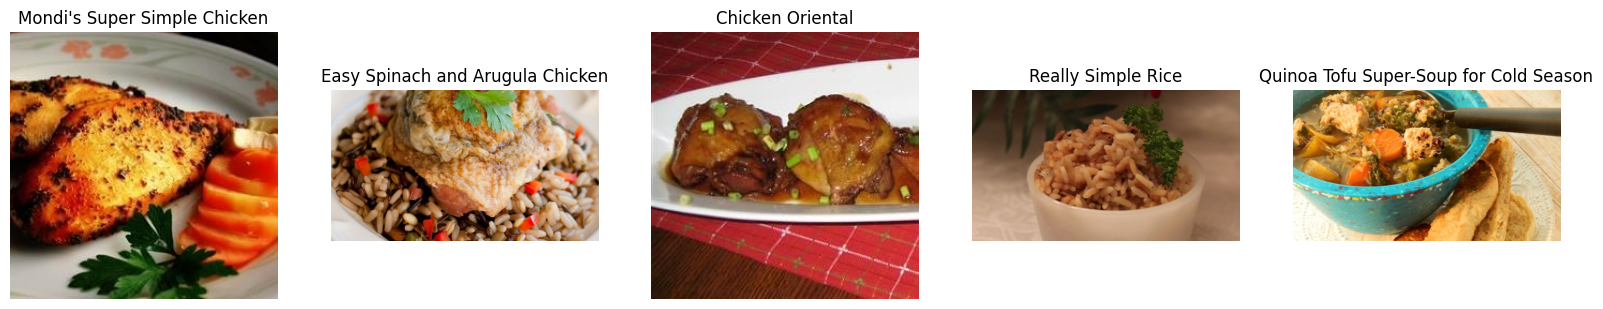

In [18]:
start = time()
cur.execute("""
    select *, (vectors <=> '[-6.14573777e-01,  8.86273831e-02, -7.35815883e-01,  2.15724006e-01,
         3.48916322e-01,  1.62261009e-01,  3.47297639e-01, -7.06387870e-03,
        -1.51828989e-01,  4.75801587e-01,  3.24733853e-02,  1.83092877e-01,
         4.81767744e-01,  1.75806969e-01,  5.48479795e-01, -4.50854897e-01,
         2.95956820e-01, -4.16116953e-01, -5.44948161e-01,  1.92423806e-01,
         3.91748842e-03,  4.77480054e-03,  7.03427063e-04,  5.41576496e-03,
         3.42545348e-03,  2.51502581e-03,  1.11971974e-03]') as cosine
from food
ORDER BY cosine
LIMIT 6
    """)

recipe_id_list = []
recipe_name_list = []
image_list = []
image_path = '/media/study/Data_Science/Food/Version_1.1/raw-data-images/{}.jpg'

for i in range(6):
    a = cur.fetchone()
    recipe_id_list.append(a[1])
    image_list.append(image_path.format(a[1]))
    recipe_name_list.append(a[2])

recipe_id_list = recipe_id_list[1:]
recipe_name_list = recipe_name_list[1:]
image_list = image_list[1:]

image_array = []
for imagepath in image_list:
    img = plt.imread(imagepath)
    # img = img_to_array(img, dtype='int')
    image_array.append(img)
    
fig = plt.figure(figsize=(20,20))
gs1 = gridspec.GridSpec(1, 5)
axs = []
for x in range(5):
    axs.append(fig.add_subplot(gs1[x]))
    axs[-1].imshow(image_array[x])
[axi.set_axis_off() for axi in axs]
for axi, x in zip(axs, recipe_name_list):
    axi.set_title(x)

end = time()
running_time = end - start
print('time cost: %.5f sec' %running_time)

In [19]:
cur.execute("""
    select *, (vectors <=> '[-6.14573777e-01,  8.86273831e-02, -7.35815883e-01,  2.15724006e-01,
         3.48916322e-01,  1.62261009e-01,  3.47297639e-01, -7.06387870e-03,
        -1.51828989e-01,  4.75801587e-01,  3.24733853e-02,  1.83092877e-01,
         4.81767744e-01,  1.75806969e-01,  5.48479795e-01, -4.50854897e-01,
         2.95956820e-01, -4.16116953e-01, -5.44948161e-01,  1.92423806e-01,
         3.91748842e-03,  4.77480054e-03,  7.03427063e-04,  5.41576496e-03,
         3.42545348e-03,  2.51502581e-03,  1.11971974e-03]') as cosine
from food
ORDER BY cosine
LIMIT 6
    """)

# Popularity based recommender system from database

In [66]:
import psycopg2 

conn = psycopg2.connect(host='localhost', dbname="vector_db", user="postgres", password='suyash', port=5432)

cur = conn.cursor()

In [67]:
cur.execute('select * from food where review_nums > 3500;')

In [68]:
a = cur.fetchall()

In [69]:
a[0][1]

78299